<a href="https://colab.research.google.com/github/Peheppy/CIFAR10_With_CNN/blob/main/(phas2)_CIFAR10_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 with CNNs

## Libraries and imports

In [ ]:
%%capture
!pip install torchinfo

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import v2
from torchvision import models
from torchvision.datasets.utils import download_and_extract_archive

from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import os
import random
import copy
from tqdm import tqdm
from typing import Sequence, Callable, Optional
import pickle

sns.set_style('darkgrid')

In [ ]:
def set_seed(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Leave as True to ensure determinism. Some operations may crash
    torch.use_deterministic_algorithms(False)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Dataset Setup

In [ ]:
# First two transforms are equivalent to ToTensor (deprecated)

test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225],
        ),
    ]
)

train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
download_and_extract_archive(
    "https://data.brainchip.com/dataset-mirror/cifar10/cifar-10-python.tar.gz",
    ".",
    md5="c58f30108f718f92721af3b95e74349a",
)

In [ ]:
full_train_ds = torchvision.datasets.CIFAR10(
    root = ".",
    train = True,
    download = False,
    transform = None
)

test_ds = torchvision.datasets.CIFAR10(
    root = ".",
    train = False,
    download = False,
    transform = test_transforms
)

Splitting the data

In [ ]:
prng = torch.Generator().manual_seed(42)
prng.initial_seed()

42

In [ ]:
full_train_ds.transform = train_transforms

length = len(full_train_ds)
len_val = int(0.15 * length)
len_train = length - len_val

train_ds, val_ds = torch.utils.data.random_split(
    full_train_ds, [len_train, len_val], generator=prng
)

val_ds = torch.utils.data.Subset(
    copy.deepcopy(full_train_ds), val_ds.indices
)
val_ds.dataset.transform = test_transforms

Final dataset sizes

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(42500, 7500, 10000)

## Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [ ]:
config = {
    "learning_rate": 1e-3,                              # Learning rate
    "n_epochs": 100,                                    # Number of epochs
    "bs_train": 128,                                    # Batch size for training
    "bs_val_test": 512,                                 # Batch size for evaluation
    "loss_fn": nn.CrossEntropyLoss(),                   # Loss function (instance)
    "optimizer": optim.Adam,                            # Optimizer (class)
    "patience": 8,                                      # Early stopping patience
    "pretrained": True,                                # Load ImageNet weights?
    "update_features": True,                           # 'True': feature extractor is trainable
}

## Model definition (ResNet)

In [ ]:
class ResNet18(nn.Module):
    def __init__(
            self,
            # Cifar10 number of classes
            num_classes: int = 10,
            pretrained: bool = False,
            update_features: bool = False,
        ):
        super().__init__()
        assert pretrained or update_features, "Invalid training configuration"
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.classifier = models.resnet18(weights=weights)
        for parameter in self.classifier.parameters():
            parameter.requires_grad_(update_features)

        resnet18_n_feats = 512
        self.classifier.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(resnet18_n_feats, num_classes)
        )

    def forward(self, x):
        logits = self.classifier(x)
        return logits

In [ ]:
classifier = ResNet18(
    pretrained = config["pretrained"],
    update_features = config["update_features"],
)

summary(
    classifier,
    input_size = (config["bs_train"], 3, 32, 32), # Cifar10 image size
    device = device.type,
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
ResNet18                                      [128, 10]                 --
├─ResNet: 1-1                                 [128, 10]                 --
│    └─Conv2d: 2-1                            [128, 64, 16, 16]         9,408
│    └─BatchNorm2d: 2-2                       [128, 64, 16, 16]         128
│    └─ReLU: 2-3                              [128, 64, 16, 16]         --
│    └─MaxPool2d: 2-4                         [128, 64, 8, 8]           --
│    └─Sequential: 2-5                        [128, 64, 8, 8]           --
│    │    └─BasicBlock: 3-1                   [128, 64, 8, 8]           73,984
│    │    └─BasicBlock: 3-2                   [128, 64, 8, 8]           73,984
│    └─Sequential: 2-6                        [128, 128, 4, 4]          --
│    │    └─BasicBlock: 3-3                   [128, 128, 4, 4]          230,144
│    │    └─BasicBlock: 3-4                   [128, 128, 4, 4]          295,42

## Model Definition (VGG)

In [ ]:
class VGG19(nn.Module):
    def __init__(
            self,
            # Cifar10 number of classes
            num_classes: int = 10,
            pretrained: bool = False,
            update_features: bool = False,
        ):
        super().__init__()
        assert pretrained or update_features, "Invalid training configuration"

        weights = models.VGG19_Weights.DEFAULT if pretrained else None
        self.features = models.vgg19(weights=weights).features

        for param in self.features.parameters():
            param.requires_grad_(update_features)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # CIFAR-10: após convoluções, a saída é 512x1x1
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)  # Extrai features
        x = x.view(x.size(0), -1)  # Flatten (512x1x1 → 512)
        x = self.classifier(x)  # Classifica
        return x

In [ ]:
classifier = VGG19(
    pretrained=config["pretrained"],
    update_features=config["update_features"],
).to(device)

summary(
    classifier,
    input_size = (config["bs_train"], 3, 32, 32), # Cifar10 image size
    device = device.type,
)

Layer (type:depth-idx)                   Output Shape              Param #
VGG19                                    [128, 10]                 --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [128, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [128, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [128, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [128, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [128, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [128, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [128, 256, 8, 8]          29

## Training utilities

In [ ]:
def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": float(metrics.balanced_accuracy_score(targets, predictions)),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
# Source: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(
        model,
        train_dl,
        loss_fn,
        optimizer,
        device,
    ):
    model.train()

    train_loss = AverageMeter()
    train_acc = AverageMeter()

    pbar = tqdm(train_dl, unit=" batch", position=0, leave=True)

    for train_instances, instance_labels in pbar:
        # Load data to device
        train_instances = train_instances.to(device)
        instance_labels = instance_labels.to(device)

        # Call zero grad to stop gradient from accumulating
        optimizer.zero_grad()

        # Inference
        y_pred = model(train_instances)

        # Loss computation and backpropagation
        loss = loss_fn(y_pred, instance_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Compute norm of gradients
        # Note: I implemented this for debugging. Maybe have a flag to switch it
        # on and off.
        total_grad_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_grad_norm = p.grad.detach().data.norm(2)
                total_grad_norm += param_grad_norm.item() ** 2
        total_grad_norm = total_grad_norm ** 0.5

        # Step optimizer
        # Note: If you guys want to try RMSProp, this needs to be changed
        optimizer.step()

        # Update meters
        # Note: The loss is averaged over the batch so the number of instances
        # is needed to accumulate it correctly
        train_loss.update(loss.item(), len(train_instances))
        preds = nn.functional.softmax(y_pred.detach(), dim=-1).argmax(dim=-1)
        n_correct = (preds == instance_labels).to(torch.float32)
        train_acc.update(n_correct.mean().item(), len(train_instances))

        # Update progress bar
        pbar.set_description(f"train_loss {train_loss.avg:.6f} | train_acc {train_acc.avg:.6f} | grad_norm {total_grad_norm:.6f}")

    return train_loss.avg, train_acc.avg

In [ ]:
def evaluation_step(
        model,
        evaluation_dl,
        loss_fn,
        device,
        name,
    ):
    model.eval()

    evaluation_loss = AverageMeter()
    evaluation_acc = AverageMeter()
    with torch.no_grad():
        pbar = tqdm(evaluation_dl, unit=" batch", position=0, leave=True)
        for evaluation_instances, instance_labels in pbar:
            evaluation_instances = evaluation_instances.to(device)
            instance_labels = instance_labels.to(device)

            y_pred = model(evaluation_instances)

            loss = loss_fn(y_pred, instance_labels)

            evaluation_loss.update(loss.item(), len(evaluation_instances))
            preds = nn.functional.softmax(y_pred.detach(), dim=-1).argmax(dim=-1)
            n_correct = (preds == instance_labels).to(torch.float32)
            evaluation_acc.update(n_correct.mean().item(), len(evaluation_instances))
            pbar.set_description(f"{name}_loss {evaluation_loss.avg:.7f}" \
                                 + f" | {name}_acc {evaluation_acc.avg:.7f}")
    return evaluation_loss.avg, evaluation_acc.avg

In [ ]:
def train_model(
        model,
        dataloaders,
        config,
        device,
    ):
    optimizer = config["optimizer"](
        params=model.parameters(), lr=config["learning_rate"]
    )
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max = config["n_epochs"] // 2,
        eta_min = config["learning_rate"] / 10,
    )

    if len(list(dataloaders.keys())) == 2:
        train_dl, val_dl = list(dataloaders.values())
        test_dl = None
    else:
        train_dl, val_dl, test_dl = list(dataloaders.values())


    history = {
        "train": {
            "loss": [],
            "acc": []
        },
        "valid": {
            "loss": [],
            "acc": []
        }
    }

    best_loss = float("inf")
    early_stop_counter = 0
    for i in range(config["n_epochs"]):
        print(f"Epoch {i + 1}")
        train_loss, train_acc = train_step(
            model, train_dl, config["loss_fn"], optimizer, device,
        )
        valid_loss, valid_acc = evaluation_step(
            model, val_dl, config["loss_fn"], device, "valid",
        )
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)

        if valid_loss < best_loss:
            print("Validation loss improved. Saving best model...")
            best_loss = valid_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "best_model_state_dict.pth")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stop counter: {early_stop_counter}/{config['patience']}")
            if early_stop_counter >= config["patience"]:
                print("Early stopping triggered.")
                break

    # Note: This ensures the model instance is loaded with the best weights
    # after training finishes (and also before the test loop)
    model.load_state_dict(
        torch.load("best_model_state_dict.pth", map_location=device)
    )
    if test_dl:
        print("\nFinal results:")


        test_loss, test_acc = evaluation_step(
            model, test_dl, config["loss_fn"], device, "test",
        )

        history.update(
            {
                "test": {
                    "loss": test_loss,
                    "acc": test_acc
                }
            }
        )

    return history

## DataLoaders

In [ ]:
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=config["bs_train"], shuffle=True,
    num_workers=1, pin_memory=True, drop_last=False
)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=config["bs_val_test"], shuffle=False,
    num_workers=1, pin_memory=True, drop_last=False
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=config["bs_val_test"], shuffle=False,
    num_workers=1, pin_memory=True, drop_last=False
)

Visualizando instâncias

In [ ]:
instances, targets = next(iter(test_dl))
instances.shape, targets.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]))

In [ ]:
mean = np.float32([0.485, 0.456, 0.406])
std = np.float32([0.229, 0.224, 0.225])

In [ ]:
denorm = v2.Compose(
    [
        v2.Normalize(
            mean = - mean / std, std = 1 / std
        ),
        v2.Lambda(lambda x: x.clamp(0, 1)),
    ]
)

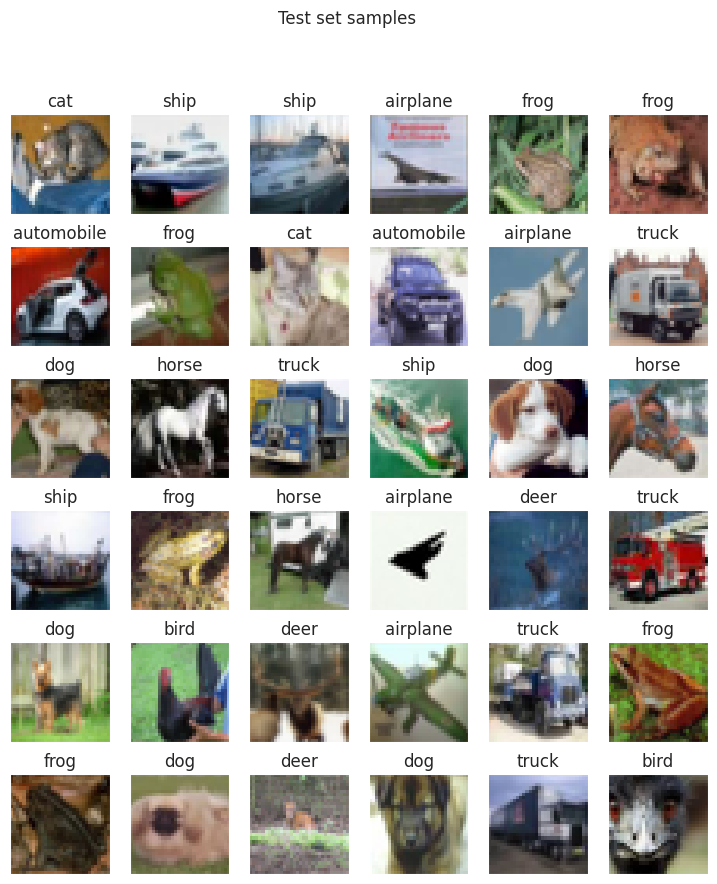

In [ ]:
w = 6
fig, ax = plt.subplots(w, w, figsize=(9, 10))
fig.suptitle("Test set samples")

for i in range(w):
  for j in range(w):
    ax[i][j].imshow(denorm(instances[i * w + j]).permute(1, 2, 0), cmap="gray", interpolation="None")
    label = test_ds.classes[targets[i * w + j].item()]
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

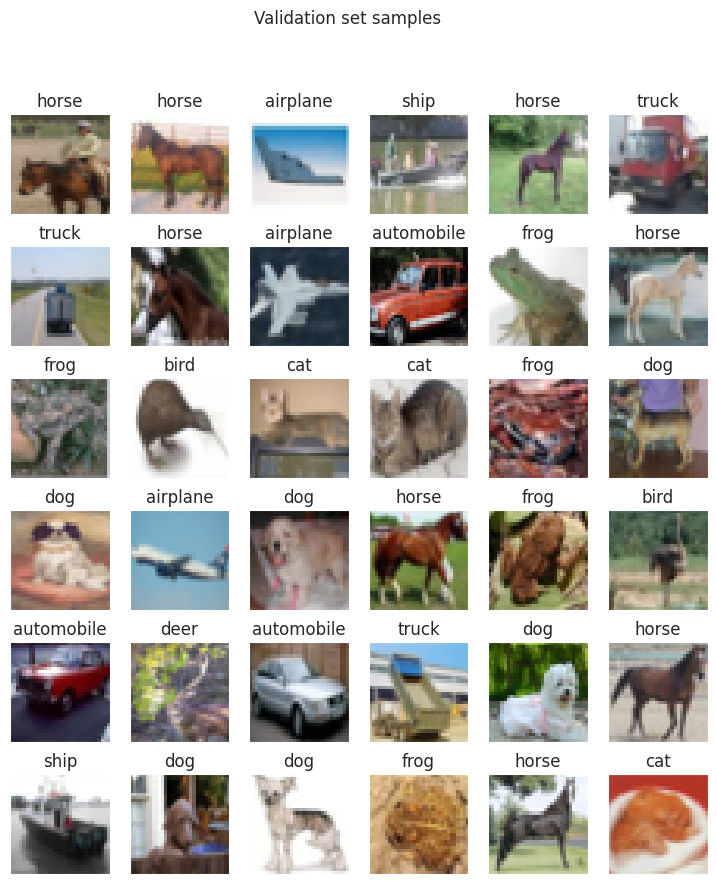

In [ ]:
instances, targets = next(iter(val_dl))

w = 6
fig, ax = plt.subplots(w, w, figsize=(9, 10))
fig.suptitle("Validation set samples")

for i in range(w):
  for j in range(w):
    ax[i][j].imshow(denorm(instances[i * w + j]).permute(1, 2, 0), cmap="gray", interpolation="None")
    label = test_ds.classes[targets[i * w + j].item()]
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

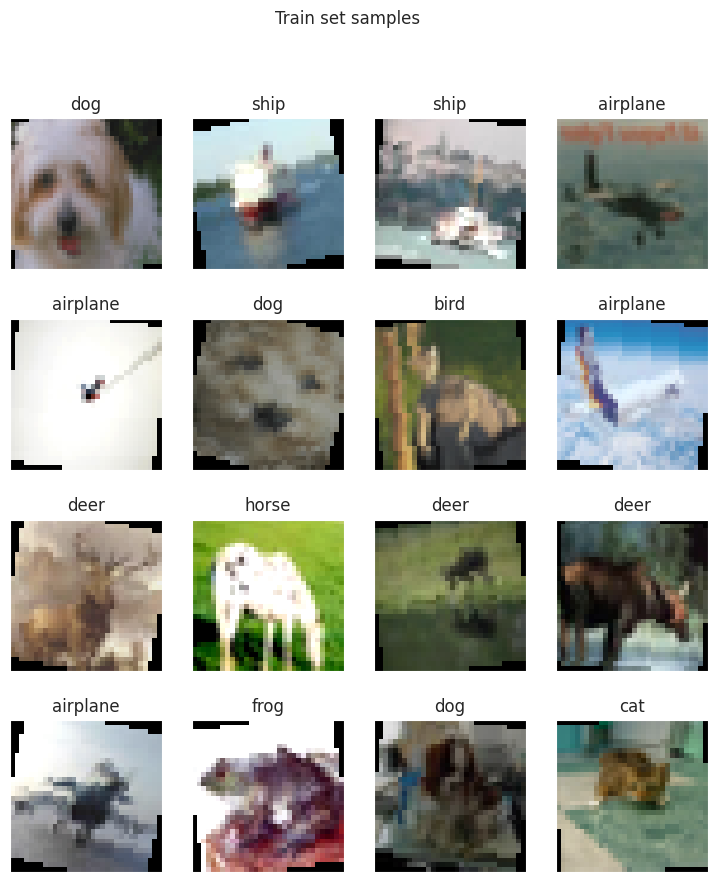

In [ ]:
w = 4
instances, targets = next(iter(train_dl))
fig, ax = plt.subplots(w, w, figsize=(9, 10))
fig.suptitle("Train set samples")

for i in range(w):
  for j in range(w):
    ax[i][j].imshow(denorm(instances[i * w + j]).permute(1, 2, 0), cmap="gray", interpolation="None")
    label = test_ds.classes[targets[i * w + j].item()]
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

## Training model

In [ ]:
dataloaders = {
    "train": train_dl,
    "val": val_dl,
    "test": test_dl
}

In [ ]:
history = train_model(classifier, dataloaders, config, device)

Epoch 1


train_loss 1.791153 | train_acc 0.280612 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.72 batch/s]
valid_loss 1.4534850 | valid_acc 0.3781333: 100%|██████████| 15/15 [00:02<00:00,  5.36 batch/s]


Validation loss improved. Saving best model...
Epoch 2


train_loss 1.247411 | train_acc 0.531153 | grad_norm 1.000000: 100%|██████████| 333/333 [00:41<00:00,  7.95 batch/s]
valid_loss 1.0269183 | valid_acc 0.6284000: 100%|██████████| 15/15 [00:03<00:00,  4.25 batch/s]


Validation loss improved. Saving best model...
Epoch 3


train_loss 0.974841 | train_acc 0.662776 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.91 batch/s]
valid_loss 0.9115763 | valid_acc 0.7060000: 100%|██████████| 15/15 [00:02<00:00,  5.50 batch/s]


Validation loss improved. Saving best model...
Epoch 4


train_loss 0.832059 | train_acc 0.724282 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.79 batch/s]
valid_loss 0.7503291 | valid_acc 0.7462667: 100%|██████████| 15/15 [00:02<00:00,  5.46 batch/s]


Validation loss improved. Saving best model...
Epoch 5


train_loss 0.744716 | train_acc 0.756965 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.86 batch/s]
valid_loss 0.6834125 | valid_acc 0.7822667: 100%|██████████| 15/15 [00:03<00:00,  4.33 batch/s]


Validation loss improved. Saving best model...
Epoch 6


train_loss 0.686282 | train_acc 0.778282 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.82 batch/s]
valid_loss 0.6466260 | valid_acc 0.7928000: 100%|██████████| 15/15 [00:02<00:00,  5.40 batch/s]


Validation loss improved. Saving best model...
Epoch 7


train_loss 0.643591 | train_acc 0.796494 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.68 batch/s]
valid_loss 0.6018403 | valid_acc 0.8090667: 100%|██████████| 15/15 [00:02<00:00,  5.44 batch/s]


Validation loss improved. Saving best model...
Epoch 8


train_loss 0.613727 | train_acc 0.806612 | grad_norm 1.000000: 100%|██████████| 333/333 [00:41<00:00,  7.96 batch/s]
valid_loss 0.5751597 | valid_acc 0.8178667: 100%|██████████| 15/15 [00:03<00:00,  4.39 batch/s]


Validation loss improved. Saving best model...
Epoch 9


train_loss 0.567374 | train_acc 0.819788 | grad_norm 1.000000: 100%|██████████| 333/333 [00:41<00:00,  7.99 batch/s]
valid_loss 0.5219459 | valid_acc 0.8370667: 100%|██████████| 15/15 [00:02<00:00,  5.42 batch/s]


Validation loss improved. Saving best model...
Epoch 10


train_loss 0.549804 | train_acc 0.828047 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.78 batch/s]
valid_loss 0.5607996 | valid_acc 0.8285333: 100%|██████████| 15/15 [00:02<00:00,  5.45 batch/s]


No improvement. Early stop counter: 1/8
Epoch 11


train_loss 0.529003 | train_acc 0.834541 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.84 batch/s]
valid_loss 0.5903148 | valid_acc 0.8218667: 100%|██████████| 15/15 [00:03<00:00,  4.22 batch/s]


No improvement. Early stop counter: 2/8
Epoch 12


train_loss 0.511306 | train_acc 0.842165 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.90 batch/s]
valid_loss 0.5403857 | valid_acc 0.8268000: 100%|██████████| 15/15 [00:02<00:00,  5.42 batch/s]


No improvement. Early stop counter: 3/8
Epoch 13


train_loss 0.484343 | train_acc 0.850259 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.70 batch/s]
valid_loss 0.5008770 | valid_acc 0.8452000: 100%|██████████| 15/15 [00:02<00:00,  5.44 batch/s]


Validation loss improved. Saving best model...
Epoch 14


train_loss 0.466311 | train_acc 0.854729 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.87 batch/s]
valid_loss 0.4751877 | valid_acc 0.8534667: 100%|██████████| 15/15 [00:03<00:00,  4.16 batch/s]


Validation loss improved. Saving best model...
Epoch 15


train_loss 0.450657 | train_acc 0.861129 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.84 batch/s]
valid_loss 0.5424264 | valid_acc 0.8368000: 100%|██████████| 15/15 [00:02<00:00,  5.36 batch/s]


No improvement. Early stop counter: 1/8
Epoch 16


train_loss 0.431522 | train_acc 0.869412 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.68 batch/s]
valid_loss 0.5744805 | valid_acc 0.8496000: 100%|██████████| 15/15 [00:02<00:00,  5.53 batch/s]


No improvement. Early stop counter: 2/8
Epoch 17


train_loss 0.427982 | train_acc 0.868424 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.70 batch/s]
valid_loss 0.4719803 | valid_acc 0.8529333: 100%|██████████| 15/15 [00:02<00:00,  5.30 batch/s]


Validation loss improved. Saving best model...
Epoch 18


train_loss 0.407020 | train_acc 0.874400 | grad_norm 0.999999: 100%|██████████| 333/333 [00:42<00:00,  7.83 batch/s]
valid_loss 0.4692865 | valid_acc 0.8545333: 100%|██████████| 15/15 [00:03<00:00,  4.08 batch/s]


Validation loss improved. Saving best model...
Epoch 19


train_loss 0.389197 | train_acc 0.880329 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.81 batch/s]
valid_loss 0.4512174 | valid_acc 0.8585333: 100%|██████████| 15/15 [00:03<00:00,  4.81 batch/s]


Validation loss improved. Saving best model...
Epoch 20


train_loss 0.385973 | train_acc 0.880800 | grad_norm 0.999999: 100%|██████████| 333/333 [00:43<00:00,  7.69 batch/s]
valid_loss 0.4980402 | valid_acc 0.8540000: 100%|██████████| 15/15 [00:03<00:00,  4.71 batch/s]


No improvement. Early stop counter: 1/8
Epoch 21


train_loss 0.378691 | train_acc 0.886188 | grad_norm 0.999999: 100%|██████████| 333/333 [00:42<00:00,  7.87 batch/s]
valid_loss 0.4299884 | valid_acc 0.8669333: 100%|██████████| 15/15 [00:03<00:00,  3.87 batch/s]


Validation loss improved. Saving best model...
Epoch 22


train_loss 0.357418 | train_acc 0.890000 | grad_norm 0.932558: 100%|██████████| 333/333 [00:42<00:00,  7.76 batch/s]
valid_loss 0.4250786 | valid_acc 0.8677333: 100%|██████████| 15/15 [00:02<00:00,  5.44 batch/s]


Validation loss improved. Saving best model...
Epoch 23


train_loss 0.360481 | train_acc 0.889600 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.72 batch/s]
valid_loss 0.4613136 | valid_acc 0.8649333: 100%|██████████| 15/15 [00:03<00:00,  4.72 batch/s]


No improvement. Early stop counter: 1/8
Epoch 24


train_loss 0.350956 | train_acc 0.894071 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.81 batch/s]
valid_loss 0.4984583 | valid_acc 0.8585333: 100%|██████████| 15/15 [00:03<00:00,  4.76 batch/s]


No improvement. Early stop counter: 2/8
Epoch 25


train_loss 0.340102 | train_acc 0.895506 | grad_norm 0.639553: 100%|██████████| 333/333 [00:42<00:00,  7.80 batch/s]
valid_loss 0.4293036 | valid_acc 0.8744000: 100%|██████████| 15/15 [00:02<00:00,  5.52 batch/s]


No improvement. Early stop counter: 3/8
Epoch 26


train_loss 0.332977 | train_acc 0.899129 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.73 batch/s]
valid_loss 0.4905785 | valid_acc 0.8625333: 100%|██████████| 15/15 [00:02<00:00,  5.47 batch/s]


No improvement. Early stop counter: 4/8
Epoch 27


train_loss 0.323192 | train_acc 0.902024 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.80 batch/s]
valid_loss 0.4327915 | valid_acc 0.8680000: 100%|██████████| 15/15 [00:03<00:00,  4.31 batch/s]


No improvement. Early stop counter: 5/8
Epoch 28


train_loss 0.324609 | train_acc 0.901082 | grad_norm 1.000000: 100%|██████████| 333/333 [00:42<00:00,  7.87 batch/s]
valid_loss 0.4536868 | valid_acc 0.8632000: 100%|██████████| 15/15 [00:03<00:00,  4.58 batch/s]


No improvement. Early stop counter: 6/8
Epoch 29


train_loss 0.316891 | train_acc 0.903459 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.72 batch/s]
valid_loss 0.4498706 | valid_acc 0.8676000: 100%|██████████| 15/15 [00:03<00:00,  4.67 batch/s]


No improvement. Early stop counter: 7/8
Epoch 30


train_loss 0.333004 | train_acc 0.905082 | grad_norm 1.000000: 100%|██████████| 333/333 [00:43<00:00,  7.71 batch/s]
valid_loss 0.4994656 | valid_acc 0.8653333: 100%|██████████| 15/15 [00:03<00:00,  4.78 batch/s]


No improvement. Early stop counter: 8/8
Early stopping triggered.

Final results:


test_loss 0.4562582 | test_acc 0.8616000: 100%|██████████| 20/20 [00:03<00:00,  5.02 batch/s]


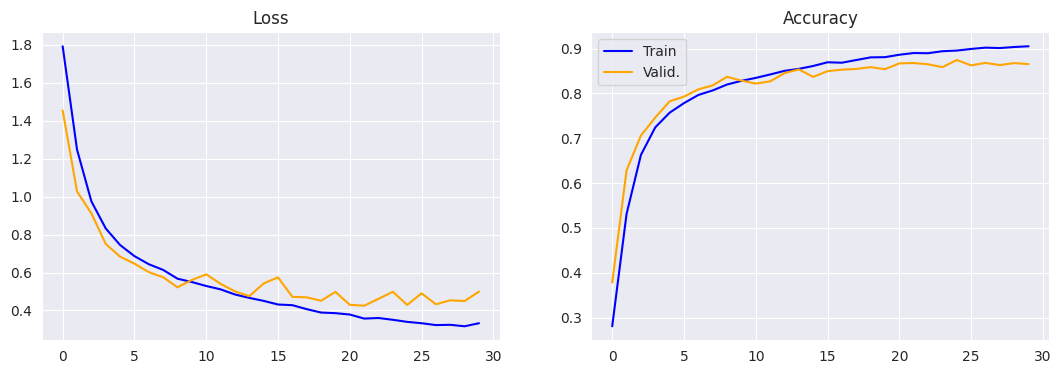

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].title.set_text("Loss")
ax[0].plot(history["train"]["loss"], c="blue", label="Train")
ax[0].plot(history["valid"]["loss"], c="orange", label="Valid.")

ax[1].title.set_text("Accuracy")
ax[1].plot(history["train"]["acc"], c="blue", label="Train")
ax[1].plot(history["valid"]["acc"], c="orange", label="Valid.")
plt.legend()

#### Visualizando resultados

Vamos visualizar algumas previsões

In [ ]:
instances, targets = next(iter(test_dl))

In [ ]:
with torch.no_grad():
    preds = classifier(instances.to(device))
    preds = nn.functional.softmax(preds.cpu(), dim=-1).argmax(dim=-1)
    all_preds = preds.flatten().tolist()

In [ ]:
plot_size = 3

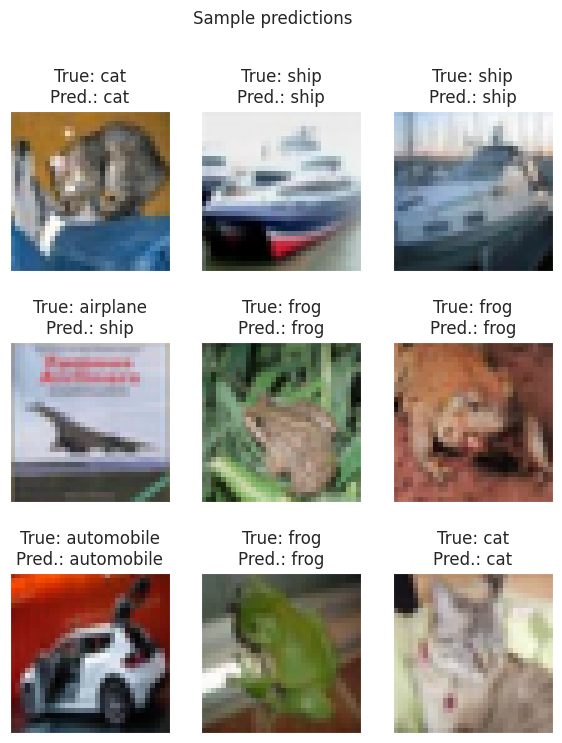

In [ ]:
fig, ax = plt.subplots(plot_size, plot_size, figsize=(7, 8.5))
plt.suptitle("Sample predictions")
for i in range(plot_size):
  for j in range(plot_size):
    ax[i][j].imshow(denorm(instances[i * plot_size + j]).permute(1, 2, 0), cmap="gray", interpolation="None")
    label = test_ds.classes[targets[i * plot_size + j].item()]
    title = f"True: {label}"
    title += f"\nPred.: {test_ds.classes[all_preds[i * plot_size + j]]}"
    ax[i][j].set_title(title)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

In [ ]:
class_assignments = {
    "true": [],
    "predicted": []
}

for (test_data, label) in tqdm(test_dl):
    test_data = test_data.to(device)
    pred = classifier(test_data).cpu()
    pred = nn.functional.softmax(pred, dim=-1).argmax(dim=-1)
    class_assignments["true"].extend(label.tolist())
    class_assignments["predicted"].extend(pred.tolist())

100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


#### Obtendo métricas

In [ ]:
print(
    classification_report(
        class_assignments["true"],
        class_assignments["predicted"],
        digits = 3,
        zero_division = 0,
        target_names = test_ds.classes
    )
)

              precision    recall  f1-score   support

    airplane      0.894     0.825     0.858      1000
  automobile      0.939     0.936     0.937      1000
        bird      0.781     0.853     0.815      1000
         cat      0.765     0.672     0.715      1000
        deer      0.836     0.859     0.848      1000
         dog      0.771     0.836     0.802      1000
        frog      0.902     0.899     0.900      1000
       horse      0.906     0.896     0.901      1000
        ship      0.907     0.930     0.919      1000
       truck      0.922     0.910     0.916      1000

    accuracy                          0.862     10000
   macro avg      0.862     0.862     0.861     10000
weighted avg      0.862     0.862     0.861     10000



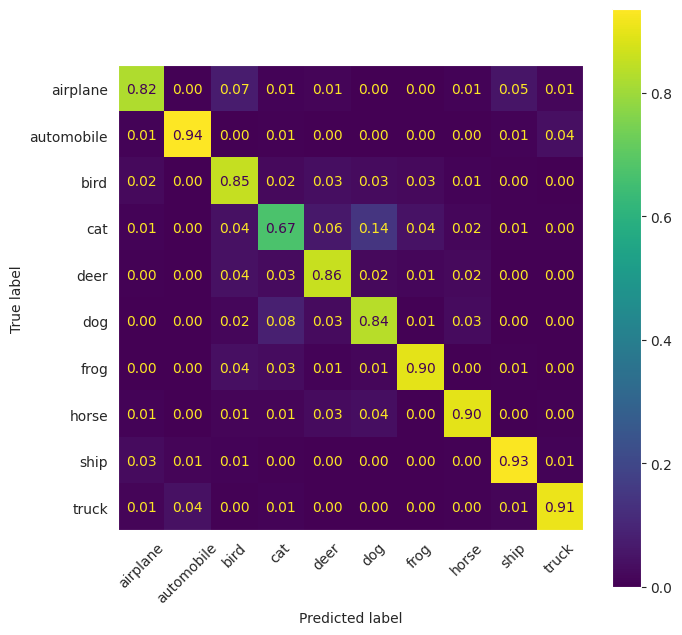

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.grid(False)
cmd = ConfusionMatrixDisplay.from_predictions(
    class_assignments["true"],
    class_assignments["predicted"],
    display_labels = test_ds.classes,
    normalize='true',
    values_format='.2f',
    xticks_rotation=45,
    ax=ax
)

In [ ]:
scores = get_scores(
    class_assignments["true"],
    class_assignments["predicted"],
)

scores

{'accuracy': 0.8616,
 'balanced_accuracy': 0.8615999999999999,
 'precision': 0.8622889671257405,
 'recall': 0.8616,
 'f1_score': 0.8611841311839648}